In [1]:
import gc
gc.collect()

227

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
print("Number of available GPU's: ", len(tf.config.experimental.list_physical_devices("GPU")))

Number of available GPU's:  1


In [5]:
import os
if "CNN" in os.path.abspath(os.curdir): os.chdir("..")
BASE_DIR = os.path.abspath(os.curdir)
BASE_DIR

'D:\\TheCompleteML\\projects'

In [6]:
data_dir = os.path.join(BASE_DIR, "datasets", "classification", "flowers")

In [7]:
data_dirs = [os.path.join(data_dir, dir_) for dir_ in os.listdir(data_dir) if "processed" not in dir_]

In [8]:
data_dirs

['D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\daisy',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\dandelion',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\rose',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\sunflower',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\tulip']

## Preprocessing

In [9]:
import random
from skimage import io

class loading_and_splitting:
    
    def __init__(self, data_dirs, dims, channels=3, target_dir=data_dir):
        self.total_images = 0
        self.minh = np.inf
        self.minw = np.inf
        self.dims = dims
        self.channels = channels
        self.target_dir = target_dir
        self.data_dirs = data_dirs
        self.class_map = {k:v.split("\\")[-1] for k, v in enumerate(data_dirs)}
        
        self.header_list = [f"x{i}" for i in range(self.dims[0]*self.dims[1]*self.channels)] + ["label"]
        self.sample_list = [random.sample(range(len(os.listdir(path))), 
                                          len(os.listdir(path))) for path in data_dirs]
        for item in self.sample_list:
            self.total_images += len(item)
        self.generate_samples()
        
    
    def generate_csvs(self):
        header_list = [f"x{i}" for i in range(self.dims[0]*self.dims[1]*self.channels)] + ["label"]
        for set_ in ["train", "valid", "test"]:
            with open(os.path.join(self.target_dir, f"{set_}.csv"), "w") as f:
                df = pd.DataFrame(list(), columns=header_list)
                df.to_csv(f, index=False)
                
    def generate_samples(self):
        self.sample_seq = random.sample(range(self.total_images), self.total_images)
        self.train_seq = self.sample_seq[:int(len(self.sample_seq)*0.8)]
        self.valid_seq = self.sample_seq[int(len(self.sample_seq)*0.8):int(len(self.sample_seq)*0.9)]
        self.test_seq = self.sample_seq[int(len(self.sample_seq)*0.9):]
    
    def crop_image(self, image):
        h, w, d = image.shape
        if h >= self.minh and w >= self.minw:
            image = image[int(h/2)-64:int(h/2)+64, 
                          int(w/2)-64:int(w/2)+64, 
                          :]
            return image
    
    def crop_or_pad(self, image):
        image = tf.image.resize_with_crop_or_pad(image, self.dims[0], self.dims[0])
        return image.numpy()
    
    def shuffle_and_save(self):
        empty = []
        train = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        valid = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        test = np.zeros((1, self.dims[0]*self.dims[1]*self.channels + 1))
        count = 0
        while len(empty) != len(self.data_dirs):
            sel_dir = np.random.randint(0, len(self.data_dirs))
            if sel_dir in empty: continue
            dir_ = self.data_dirs[sel_dir]
            if not self.sample_list[sel_dir]:
                empty.append(sel_dir)
            else:
                count += 1
                print(f"Processing: {count}")
                sel_image = self.sample_list[sel_dir].pop()
                image = io.imread(os.path.join(dir_, os.listdir(dir_)[sel_image]))
                
                h, w, d = image.shape
                if h < self.minh: self.minh = h
                if w < self.minw: self.minw = w
                if self.minh < self.dims[0]: self.minh = self.dims[0]
                if self.minw < self.dims[1]: self.minw = self.dims[1]
                
                # image = self.crop_image(image)
                image = self.crop_or_pad(image)
                
                if not isinstance(image, np.ndarray): continue
                if sel_image in self.train_seq: 
                    train = np.append(train, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
                elif sel_image in self.valid_seq: 
                    valid = np.append(valid, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
                elif sel_image in self.test_seq: 
                    test = np.append(test, np.append(image.flatten(), sel_dir).reshape(1,-1), axis=0)
        
        train = train[1:, :]
        valid = valid[1:, :]
        test = test[1:, :]
        
        for prefix, arr in zip(["train", "valid", "test"], [train, valid, test]):
            self.split_and_save(arr, os.path.join(self.target_dir, "processed", prefix), prefix)
        
    def split_and_save(self, arr, target_dir, prefix, split_count=10):
        os.makedirs(target_dir, exist_ok=True)
        for i in range(split_count):
            df = pd.DataFrame(arr[i*int(arr.shape[0]//split_count):(i+1)*int(arr.shape[0]//split_count), :], 
                             columns=self.header_list)
            df.to_csv(os.path.join(target_dir, "{}_{}.csv".format(prefix, i+1)), index=False)

In [10]:
dims = (150, 150)
channels = 3
n_features = dims[0] * dims[1] * channels
ls = loading_and_splitting(data_dirs=data_dirs, dims=dims, channels=channels, target_dir=data_dir)
class_map = ls.class_map
class_map
# ls.shuffle_and_save()

{0: 'daisy', 1: 'dandelion', 2: 'rose', 3: 'sunflower', 4: 'tulip'}

In [11]:
set_dir = os.path.join(data_dir, "processed")
train_paths = [f"{os.path.join(set_dir, 'train')}\\{item}" for item in os.listdir(os.path.join(set_dir, "train"))]
valid_paths = [f"{os.path.join(set_dir, 'valid')}\\{item}" for item in os.listdir(os.path.join(set_dir, "valid"))]
test_paths = [f"{os.path.join(set_dir, 'test')}\\{item}" for item in os.listdir(os.path.join(set_dir, "test"))]

In [12]:
data_augmentation = tf.keras.Sequential([keras.layers.RandomFlip("horizontal_and_vertical"), 
                                         keras.layers.RandomRotation(0.2),
                                         keras.layers.RandomContrast(0.5),
                                         keras.layers.RandomZoom((-0.3, 0.3), (-0.3, 0.3))
                                         ])

def preprocess(line):
    defs = [tf.constant([], dtype = tf.float32)] * (n_features + 1)
    xy = tf.io.decode_csv(line, record_defaults=defs)
    X = tf.stack(xy[:-1])
    y = tf.stack(xy[-1:])
    
    # prcessing steps
    X = tf.divide(X, 255)
    X = tf.reshape(X, [dims[0], dims[1], channels])
    X = data_augmentation(X)
    X = tf.image.rot90(X)
    X = tf.image.random_brightness(X, 0.2)
    
    return X, y


def preprocess_test(X):
    # prcessing steps
    
    X = tf.image.resize_with_crop_or_pad(X, 150 ,150)
    X = data_augmentation(X)
    X = tf.image.rot90(X)
    X = tf.image.random_brightness(X, 0.2)
    X = tf.divide(X, 255)
    
    return X

In [13]:
def read_csv_pipeline(paths, n_readers, n_repeat, shuffle_buffer_size, n_read_threds, n_parse_threads, batch_size):
    filepaths = tf.data.Dataset.list_files(paths, seed=42)
    dataset = filepaths.interleave(lambda filepath: tf.data.TextLineDataset(filepath).skip(1), cycle_length=n_readers)
    dataset = dataset.shuffle(shuffle_buffer_size).repeat(n_repeat)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

In [ ]:
n_readers = 5
n_repeat = 8
shuffle_buffer_size = 400
n_read_threads = None
n_parse_threads = 5
batch_size = 32

train_set = read_csv_pipeline(train_paths, n_readers, 
                              n_repeat, shuffle_buffer_size, 
                              n_read_threads, n_parse_threads, 
                              batch_size)

valid_set = read_csv_pipeline(valid_paths, n_readers, 
                              n_repeat, shuffle_buffer_size, 
                              n_read_threads, n_parse_threads, 
                              batch_size)

test_set = read_csv_pipeline(test_paths, n_readers, 
                              n_repeat, shuffle_buffer_size, 
                              n_read_threads, n_parse_threads, 
                              batch_size)

### Model Training

In [ ]:
class ResidualLayer(keras.layers.Layer):
    
    def __init__(self, fm, strides=1, ksize=3, padding="same", activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.fm = fm
        self.ksize = ksize
        self.strides = strides
        self.padding = padding
        self.activation = keras.activations.get(activation)
        self.normalization = keras.layers.BatchNormalization()
        self.mainc_layers = [keras.layers.Conv2D(self.fm, 
                                                 kernel_size=self.ksize, 
                                                 strides=self.strides, 
                                                 padding=self.padding, 
                                                 use_bias=False),
                            self.normalization, 
                            self.activation,
                            keras.layers.Conv2D(self.fm, 
                                                kernel_size=self.ksize, 
                                                strides=1, 
                                                padding=self.padding, 
                                                use_bias=False),
                            self.normalization]
        self.skipc_layers = []
        if strides > 1:
            self.skipc_layers = [keras.layers.Conv2D(self.fm, 
                                                     kernel_size=1, 
                                                     strides=self.strides, 
                                                     padding=self.padding,
                                                     use_bias=False),
                                self.normalization]
    def get_config(self):
        config = super().get_config()
        config.update({"fm": self.fm,
                        "ksize": self.ksize,
                        "strides": self.strides,
                        "padding": self.padding,
                        "activation": self.activation
                        })
        return config
    
    def call(self, inputs):
        z = inputs
        for layer in self.mainc_layers:
            z = layer(z)
        skip_z = inputs
        for layer in self.skipc_layers:
            skip_z = layer(skip_z)
        return self.activation(z+skip_z)

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def resnet_model():

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=64, kernel_size=7, 
                                  strides=2, padding="same", 
                                  use_bias=False,
                                  input_shape=[dims[0], dims[1], channels]))
    model.add(keras.layers.Normalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2)) # pool size is three, strides is 2 and padding is same
    pfm = 64
    for fm in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 6: # 512 should be repeated 3 times instead of 6
        strides = 1 if fm == pfm else 2
        model.add(ResidualLayer(fm=fm, strides=strides))
        pfm = fm
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
              optimizer=keras.optimizers.Nadam(),
              metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "flowers_cnn_with_resnet_model.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks    

In [24]:
model, callbacks = resnet_model()

In [26]:
history = model.fit(train_set, epochs=25, validation_data=valid_set,
                   callbacks=callbacks)

Epoch 1/25
325/325 [==============================] - 534s 2s/step - loss: 1.5389 - sparse_categorical_accuracy: 0.4515 - val_loss: 2.0277 - val_sparse_categorical_accuracy: 0.2937
Epoch 2/25
325/325 [==============================] - 445s 1s/step - loss: 1.0884 - sparse_categorical_accuracy: 0.5789 - val_loss: 1.4646 - val_sparse_categorical_accuracy: 0.3603
Epoch 3/25
325/325 [==============================] - 351s 1s/step - loss: 0.9444 - sparse_categorical_accuracy: 0.6408 - val_loss: 1.6137 - val_sparse_categorical_accuracy: 0.2341
Epoch 4/25
325/325 [==============================] - 356s 1s/step - loss: 0.8733 - sparse_categorical_accuracy: 0.6674 - val_loss: 1.9676 - val_sparse_categorical_accuracy: 0.2389
Epoch 5/25
325/325 [==============================] - 349s 1s/step - loss: 0.7960 - sparse_categorical_accuracy: 0.6980 - val_loss: 1.6316 - val_sparse_categorical_accuracy: 0.3865
Epoch 6/25
325/325 [==============================] - 360s 1s/step - loss: 0.7178 - sparse_cate

In [63]:
def plot_losses_and_accuracy(history, ylim=(0, 1)):
    pd.DataFrame(history.history).plot(figsize=(8, 5)) 
    plt.grid(True) 
    plt.gca().set_ylim(*ylim) # set the vertical range to [0-1] 
    plt.show()

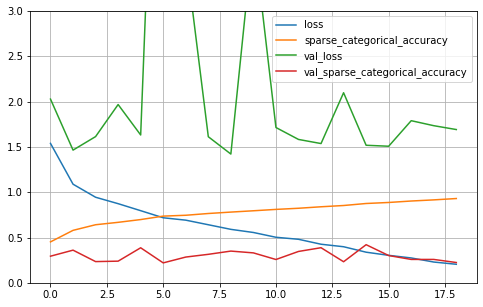

In [67]:
plot_losses_and_accuracy(history, ylim=(0, 3))

##### Observations

Here model clearly seems to have overfitting. So we need to put some constraints to reduce the overfitting

Constraints to reduce overfitting for CNN
- Reduce layers and hidden units
- Regularization
- Weight Initilizatin
- Dropout Regularization
- Weight Constraints
- Other methods

In [187]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


def cnn_mp_r3_de():
    """
    name ecodes the model architecture
    cnn followed by max pooling repeated three times, followed by dense layer
    """

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=5, 
                                  strides=2, padding="same", 
                                  use_bias=False, 
                                  input_shape=[dims[0], dims[0], channels], 
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(128, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False, 
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Conv2D(256, kernel_size=3, 
                                  strides=1, padding="same", 
                                  use_bias=False, 
                                  activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "flowers_cnn_mp_r3_de.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [188]:
model, callbacks = cnn_mp_r3_de()

In [192]:
history = model.fit(train_set, epochs=25, 
                    validation_data=valid_set, callbacks=callbacks)

Epoch 1/25
865/865 [==============================] - 901s 1s/step - loss: 1.2241 - sparse_categorical_accuracy: 0.4967 - val_loss: 1.0431 - val_sparse_categorical_accuracy: 0.5890
Epoch 2/25
865/865 [==============================] - 919s 1s/step - loss: 1.0072 - sparse_categorical_accuracy: 0.6105 - val_loss: 0.9015 - val_sparse_categorical_accuracy: 0.6292
Epoch 3/25
865/865 [==============================] - 950s 1s/step - loss: 0.8769 - sparse_categorical_accuracy: 0.6632 - val_loss: 0.8222 - val_sparse_categorical_accuracy: 0.6676
Epoch 4/25
865/865 [==============================] - 920s 1s/step - loss: 0.8119 - sparse_categorical_accuracy: 0.6933 - val_loss: 0.7644 - val_sparse_categorical_accuracy: 0.7042
Epoch 5/25
865/865 [==============================] - 913s 1s/step - loss: 0.7554 - sparse_categorical_accuracy: 0.7133 - val_loss: 0.7606 - val_sparse_categorical_accuracy: 0.7065
Epoch 6/25
865/865 [==============================] - 923s 1s/step - loss: 0.6971 - sparse_cate

##### Observations

Here we have a vanishing gradient problem, we can use following aproch to reduce it. 

- He normal initializer with relu activations
- Batch Normalization
- Add some layers with reidualnetwork 
- Dropouts should be added to reduce the overfitting


One approch is to use lower layers of already trained netowrk and implement some normalization, initilization and dropout techniques to appended layers and make freeze all the pretrained layer during training this updated model. But important point is that tranfer learning aproch will not work well for small dense network as compare to DNN,beacause lower layers in DNN learned more general patterns so can be usefull and improved.

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

def mini_resnet_9cl():
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=64,
                                kernel_size=5, 
                                strides=2, 
                                padding="same", 
                                use_bias=False, 
                                input_shape=[dims[0], dims[1], channels]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
    pfm = 64
    for fm in [64, 128, 256, 512]:
        strides = 1 if pfm == fm else 2
        model.add(ResidualLayer(fm=fm, strides=strides))
        pfm = fm
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(5, activation="softmax"))
    
    model.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                  optimizer="nadam", 
                  metrics=keras.metrics.sparse_categorical_accuracy)
    
    model_target = os.path.join(BASE_DIR, "models", "mini_resnet_9cl.h5")
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model_target, save_best_only=True)
    early_stop_cb = keras.callbacks.EarlyStopping(patience=10)
    callbacks = [checkpoint_cb, early_stop_cb]
    
    return model, callbacks

In [ ]:
model, callbacks = mini_resnet_9cl()

In [ ]:
history = model.fit(train_set, epochs=25, validation_data=valid_set, callbacks=callbacks)